# Uncertainty Analysis

The following tutorial demonstrates how one may perform an uncertainty analysis of a simulation model via `calisim`. We will first import our required dependencies.

In [59]:
from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.example_models import SirOdesModel
from calisim.uncertainty import (
	UncertaintyAnalysisMethod,
	UncertaintyAnalysisMethodModel,
)
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

## SIR Model Parameters and Initial Conditions

We next define our forward model. We will use an SIR (susceptible, infected, and recovered) compartmental model, combined with SciPy's solver for ordinary differential equations. The SIR model is expressed as a system of ordinary differential equations where:

| Parameter | Value | Description |
|-----------|-------|-------------|
| β (beta)  | 0.4   | Infection rate: probability of transmission per contact per time unit |
| γ (gamma) | 0.1   | Recovery rate: fraction of infected recovering per time unit |
|           |       | **Average infectious period = 1 / γ = 10 time units** |

With the following compartments:

| Compartment | Symbol | Initial Value | Description |
|------------|--------|---------------|-------------|
| Susceptible | S0     | 999           | Individuals who can catch the disease (N - I0 - R0) |
| Infected    | I0     | 1.0           | Individuals currently infected and can spread the disease |
| Recovered   | R0     | 0             | Individuals recovered or removed; no longer infectious |

In [60]:
def sir_simulate(parameters: dict) -> np.ndarray | pd.DataFrame:
    def dX_dt(_: np.ndarray, X: np.ndarray) -> np.ndarray:
        S, I, _ = X
        dotS = -parameters["beta"] * S * I / parameters["N"]
        dotI = (
            parameters["beta"] * S * I / parameters["N"] - parameters["gamma"] * I
        )
        dotR = parameters["gamma"] * I
        return np.array([dotS, dotI, dotR])

    X0 = [parameters["S0"], parameters["I0"], parameters["R0"]]
    t = (parameters["t"].min(), parameters["t"].max())
    x_y = solve_ivp(
        fun=dX_dt, y0=X0, t_span=t, t_eval=parameters["t"].values.flatten()
    ).y

    df = pd.DataFrame(dict(dotS=x_y[0, :], dotI=x_y[1, :], dotR=x_y[2, :]))
    return df

We will perform a simulation study with the following ground-truth parameters:

In [61]:
model = SirOdesModel()
pd.DataFrame(model.GROUND_TRUTH, index=[0])

,beta,gamma,N,I0,R0,S0
0,0.4,0.1,1000,1.0,0,999.0


When supplied to our forward model, these ground-truth parameters will generate the observed data below:

In [62]:
observed_data = model.get_observed_data()
observed_data.head(6)

,dotS,dotI,dotR,day
0,999.000000,1.000000,0.000000,0
1,998.534208,1.349201,0.116592,1
2,997.906105,1.819995,0.273899,2
3,997.059813,2.454180,0.486007,3
4,995.919926,3.308098,0.771976,4
5,994.385263,4.457212,1.157524,5


Let's view the trajectory of infected individuals over time in days.

<Axes: xlabel='day', ylabel='dotI'>

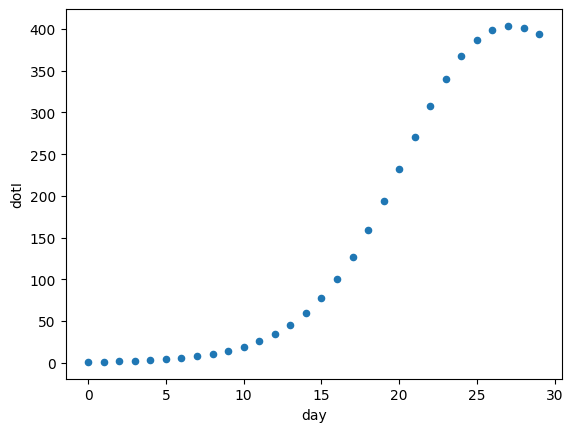

In [63]:
observed_data.plot.scatter("day", "dotI")

## Uncertainty Analysis via Polynomial Chaos

Next, let's use `calisim` to perform an uncertainty analysis of the simulated number of infected. To start with, we'll need to define our `ParameterSpecification` parameter specification:

In [64]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="beta",
			distribution_name="uniform",
			distribution_args=[0.3, 0.5],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="gamma",
			distribution_name="uniform",
			distribution_args=[0.05, 0.15],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

This contains information concerning the various parameter names, probability distributions, ranges, distribution parameters, and data types.

We next need to create a wrapper function around our forward model to ensure there's compatibility with the `calisim` API.

In [65]:
def uncertainty_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    simulation_parameters = model.GROUND_TRUTH.copy()
    simulation_parameters["t"] = t

    for k in ["beta", "gamma"]:
        simulation_parameters[k] = parameters[k]

    simulated_data = sir_simulate(simulation_parameters).dotI.values
    return simulated_data

The last step is to create an `UncertaintyAnalysisMethodModel` specification for the calibration procedure itself, which we then supply to an `UncertaintyAnalysisMethod` calibrator. We'll use the `polynomial chaos` method via the [Chaospy engine](https://chaospy.readthedocs.io/en/master/).

In [66]:
specification = UncertaintyAnalysisMethodModel(
	experiment_name="chaospy_uncertainty_analysis",
	parameter_spec=parameter_spec,
	observed_data=observed_data.dotI.values,
	solver="linear",
	algorithm="least_squares",
	method="sobol",
	order=2,
	n_samples=200,
	output_labels=["Number of Infected"],
	calibration_func_kwargs=dict(t=observed_data.day)
)

calibrator = UncertaintyAnalysisMethod(
	calibration_func=uncertainty_func, specification=specification, engine="chaospy"
)

Finally, we'll run the calibration procedure. This is composed of 3 steps:

1. **Specify**: Define your calibration problem: Parameter distributions, observed data, objective/discrepancy function, and calibration settings (like algorithm, directions, iterations)
2. **Execute**: Run the actual calibration process (simulation + optimization/inference)
3. **Analyze**: Process, summarize, and optionally save plots/metrics of the calibration results

Or **SEA**.

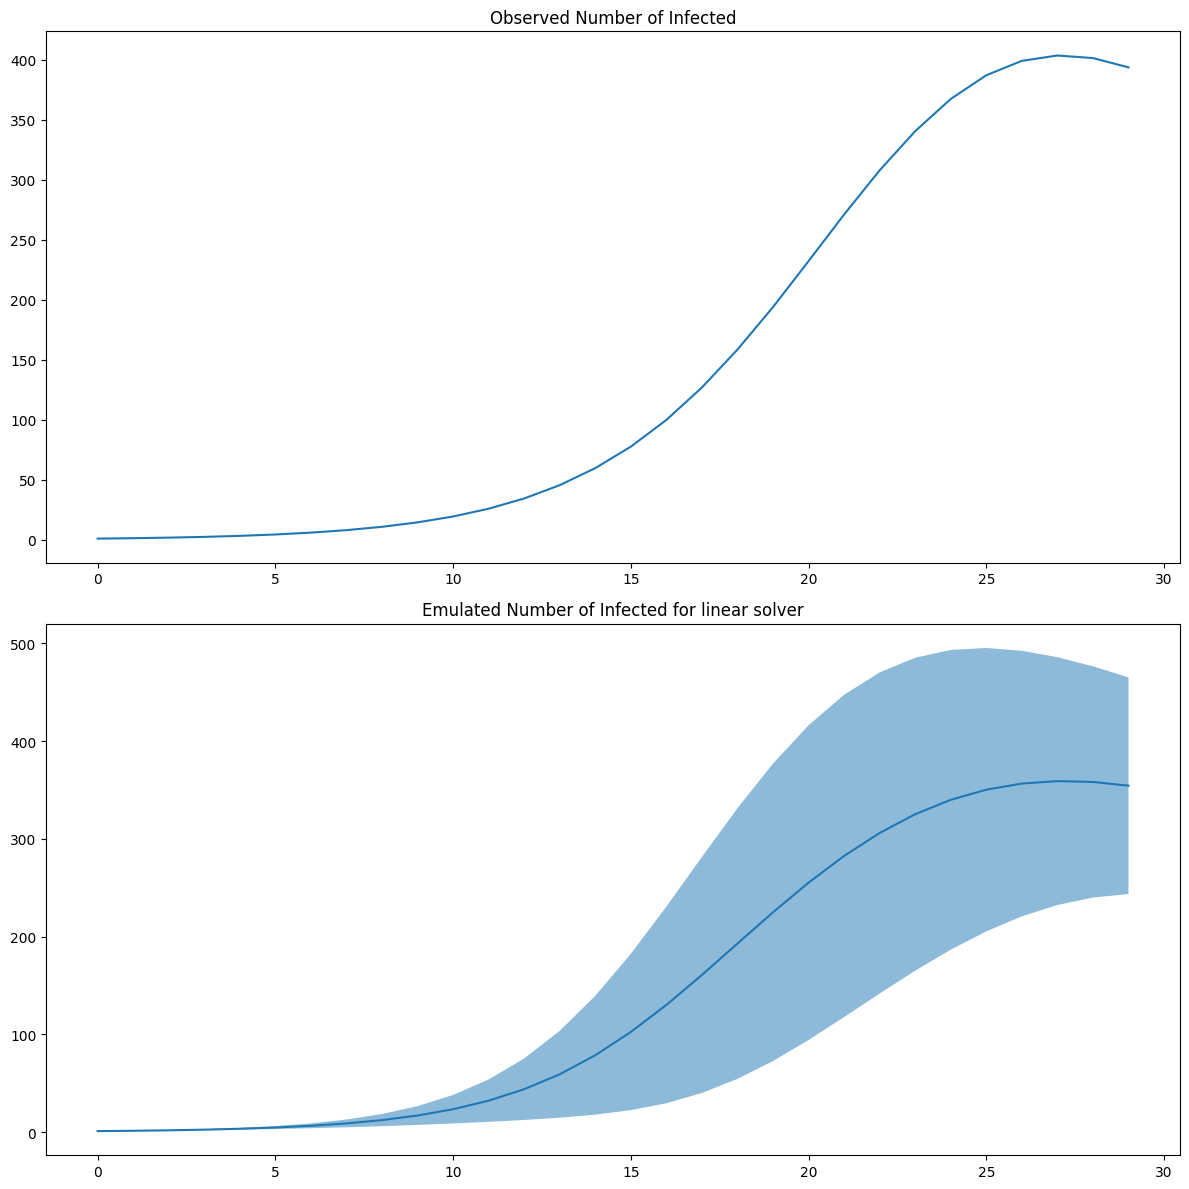

In [67]:
calibrator.specify().execute().analyze()

We can see that the uncertainty of the infected number increases over time relatively proportionately to the number of infections.

## Uncertainty Analysis via Polynomial Chaos by Quadrature

Let's repeat the uncertainty analysis procedure above using `polynomial chaos` via the `chaospy` library. But this time by quadrature.

We can reuse both the parameter specification and wrapper function defined above. But we will need to change the calibration specification. One advantage of `calisim` is the ability to compare different calibration algorithms with minimal code changes.

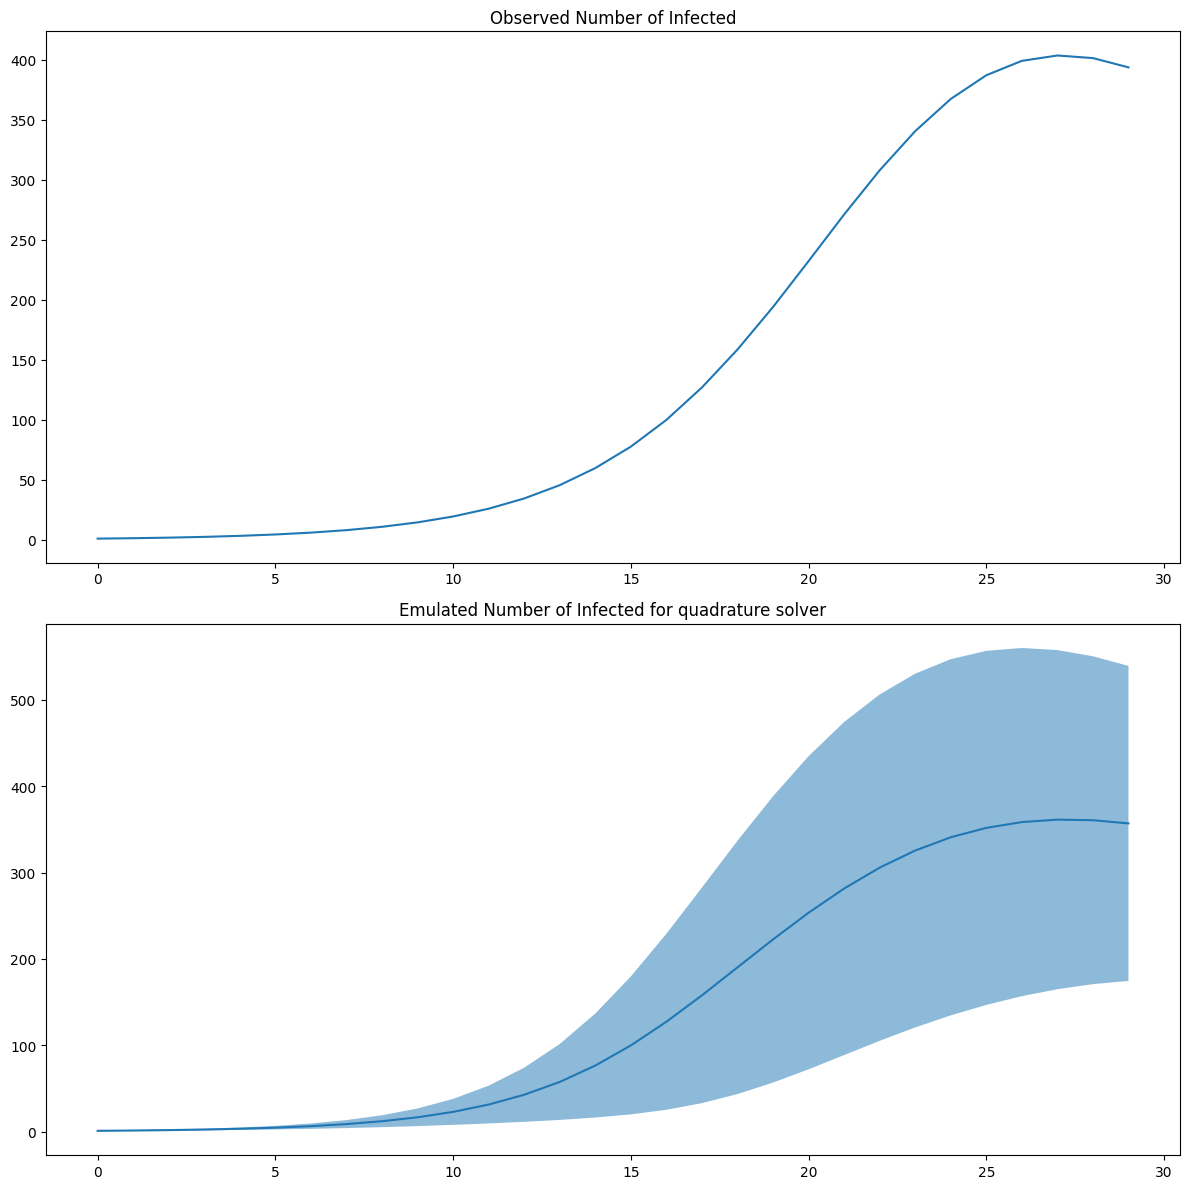

In [68]:
specification.solver="quadrature"
specification.method="grid"

calibrator = UncertaintyAnalysisMethod(
	calibration_func=uncertainty_func, specification=specification, engine="chaospy"
)

calibrator.specify().execute().analyze()

We can see that the uncertainty of the infected number increases over time relatively proportionately to the number of infections.

When performing the uncertainty analysis via quadrature by constructing a grid, the prediction intervals appear to be wider than when using a `linear` solver and `Sobol` sampling.